#### **Deploy de aplicações**

#### **Observações**

#### **Conteúdo - Bases e Notebook da aula**

Github:  
https://github.com/FIAP/Pos_Tech_DTAT/tree/dd201a034223a16732c6f639b40600b26bd3129c

Como criar ambientes para evitar conflito:  
https://github.com/RicardViana/fiap-data-viz-and-production-models/blob/main/Roteiro%20para%20cria%C3%A7%C3%A3o%20de%20ambiente.pdf

Base Credit Card Approval Predictio do Kaggle:  
https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

#### **Importação de bibliotecas**

In [70]:
# Importar biblioteca completa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np

# Importar algo especifico de uma biblioteca

#### **Funções (def)**

#### **Aula 1 - Tratando os dados**

In [2]:
# Importar dados cadastrado 

link = 'https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/dd201a034223a16732c6f639b40600b26bd3129c/dados/clientes_cadastrados.csv'
cadastrados = pd.read_csv(link, sep= ",")

In [3]:
# Ver os primeiros dados 

cadastrados.head()

,ID_Cliente,Genero,Tem_carro,Tem_casa_propria,Qtd_filhos,Rendimento_anual,Categoria_de_renda,Grau_escolaridade,Estado_civil,Moradia,Idade,Anos_empregado,Tem_celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_familia
0,5008804,M,Y,Y,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,-21474,-1134,1,0,0,0,Segurança,2.0
3,5008808,F,N,Y,0,270000.0,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,-19110,-3051,1,0,1,1,Vendas,1.0
4,5008809,F,N,Y,0,270000.0,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,-19110,-3051,1,0,1,1,Vendas,1.0


In [4]:
# Ver os a qtd de linhas e colunas

cadastrados.shape

(438557, 18)

In [5]:
# Ver clientes duplicados

contagem = cadastrados['ID_Cliente'].value_counts()
contagem[contagem > 1]

ID_Cliente
7702516    2
7602432    2
7836971    2
7213374    2
7052783    2
7023651    2
7838075    2
7636389    2
7052812    2
7372589    2
7155150    2
7090931    2
7091721    2
7137299    2
7744386    2
7772847    2
7636756    2
7317997    2
7053557    2
7742853    2
7576316    2
7099881    2
7046068    2
7036518    2
7742298    2
7022197    2
7603224    2
7023108    2
7089090    2
7702238    2
7243768    2
7045885    2
7836711    2
7743418    2
7045794    2
7618285    2
7207977    2
7154598    2
7154819    2
7024111    2
7282535    2
7050948    2
7416167    2
7174719    2
7833087    2
7135270    2
7022327    2
Name: count, dtype: int64

In [6]:
# Ver qtd de registros duplicados

cadastrados[cadastrados['ID_Cliente'].duplicated(keep=False)].shape


(94, 18)

In [7]:
# Filtrar apenas clientes com ID duplicado

ids_duplicados = cadastrados['ID_Cliente'].duplicated(keep=False).copy()
cadastrados[ids_duplicados].sort_values('ID_Cliente')

,ID_Cliente,Genero,Tem_carro,Tem_casa_propria,Qtd_filhos,Rendimento_anual,Categoria_de_renda,Grau_escolaridade,Estado_civil,Moradia,Idade,Anos_empregado,Tem_celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_familia
425023,7022197,F,N,Y,0,450000.0,Associado comercial,Ensino superior,Divorciado,Casa/apartamento próprio,-19813,-1799,1,0,0,1,NaN,1.0
426818,7022197,M,Y,Y,3,135000.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,-11945,-735,1,0,0,1,Construção Civil,5.0
431911,7022327,M,Y,Y,0,256500.0,Associado comercial,Ensino superior,Casado,Casa/apartamento próprio,-21503,-1674,1,0,0,1,Equipe principal,2.0
431545,7022327,F,N,Y,0,135000.0,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,-14771,-5298,1,0,0,0,Alta tecnologia,1.0
425486,7023108,M,Y,Y,1,67500.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,-15156,-1696,1,1,0,0,Equipe principal,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Empregado,Ensino superior,Casado,Casa/apartamento próprio,-13747,-4386,1,0,1,0,Contabilidade,4.0
428620,7836971,F,N,Y,0,103500.0,Empregado,Ensino médio,União-estável,Casa/apartamento próprio,-13383,-2798,1,0,1,0,Vendas,2.0
421464,7836971,M,Y,N,1,157500.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,-13771,-5520,1,0,0,0,NaN,3.0
422068,7838075,M,N,Y,0,337500.0,Associado comercial,Ensino médio,Casado,Casa/apartamento próprio,-18198,-1275,1,0,0,1,Motorista,2.0


In [8]:
# Remover os dados duplicados

id_repetidos = cadastrados[cadastrados['ID_Cliente'].duplicated(keep=False)]
df_cadastrados_limpo = cadastrados.drop(id_repetidos.index)

In [9]:
# Ver clientes duplicados novamente pós drop

contagem = df_cadastrados_limpo['ID_Cliente'].value_counts()
contagem[contagem > 1]

Series([], Name: count, dtype: int64)

In [10]:
# Filtrar apenas colunas com valores nulos

df_cadastrados_limpo.isnull().sum()[df_cadastrados_limpo.isnull().sum() > 0]

Ocupacao    134177
dtype: int64

In [11]:
# Ver os tipos de Ocupacao

df_cadastrados_limpo['Ocupacao'].unique()

array([nan, 'Segurança', 'Vendas', 'Contabilidade', 'Construção Civil',
       'Gerência', 'Motorista', 'Equipe principal', 'Alta tecnologia',
       'Limpeza', 'Serviço privado', 'Cozinha', 'Baixa qualificação',
       'Medicina', 'Secretariado', 'Garçom', 'RH', 'Corretor imobiliário',
       'TI'], dtype=object)

In [12]:
# Tratar os dados null 

df_cadastrados_limpo['Ocupacao'] = df_cadastrados_limpo['Ocupacao'].fillna(value='Outros')

In [13]:
# Filtrar apenas colunas com valores nulos

df_cadastrados_limpo.isnull().sum()

ID_Cliente               0
Genero                   0
Tem_carro                0
Tem_casa_propria         0
Qtd_filhos               0
Rendimento_anual         0
Categoria_de_renda       0
Grau_escolaridade        0
Estado_civil             0
Moradia                  0
Idade                    0
Anos_empregado           0
Tem_celular              0
Tem_telefone_trabalho    0
Tem_telefone_fixo        0
Tem_email                0
Ocupacao                 0
Tamanho_familia          0
dtype: int64

In [14]:
# Ver a qtd de registro unica de cada coluna
df_cadastrados_limpo.nunique()

ID_Cliente               438463
Genero                        2
Tem_carro                     2
Tem_casa_propria              2
Qtd_filhos                   12
Rendimento_anual            866
Categoria_de_renda            5
Grau_escolaridade             5
Estado_civil                  5
Moradia                       6
Idade                     16379
Anos_empregado             9406
Tem_celular                   1
Tem_telefone_trabalho         2
Tem_telefone_fixo             2
Tem_email                     2
Ocupacao                     19
Tamanho_familia              13
dtype: int64

In [15]:
# Remover colunas não necessarias

df_cadastrados_limpo = df_cadastrados_limpo.drop('Genero', axis=1)
df_cadastrados_limpo = df_cadastrados_limpo.drop('Tem_celular', axis=1)

In [16]:
# Ver os dados unico --> Tem_carro

df_cadastrados_limpo['Tem_carro'].unique()

array(['Y', 'N'], dtype=object)

In [17]:
# Ver os dados unico --> Tem_casa_propria

df_cadastrados_limpo['Tem_casa_propria'].unique()

array(['Y', 'N'], dtype=object)

In [18]:
# Ver os dados unico --> Tem_telefone_trabalho

df_cadastrados_limpo['Tem_telefone_trabalho'].unique()

array([1, 0])

In [19]:
# Ver os dados unico --> Tem_telefone_fixo

df_cadastrados_limpo['Tem_telefone_fixo'].unique()

array([0, 1])

In [20]:
# Ver os dados unico --> Tem_email

df_cadastrados_limpo['Tem_email'].unique()

array([0, 1])

In [21]:
# Ver os tipos de dados

df_cadastrados_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438463 entries, 0 to 438556
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID_Cliente             438463 non-null  int64  
 1   Tem_carro              438463 non-null  object 
 2   Tem_casa_propria       438463 non-null  object 
 3   Qtd_filhos             438463 non-null  int64  
 4   Rendimento_anual       438463 non-null  float64
 5   Categoria_de_renda     438463 non-null  object 
 6   Grau_escolaridade      438463 non-null  object 
 7   Estado_civil           438463 non-null  object 
 8   Moradia                438463 non-null  object 
 9   Idade                  438463 non-null  int64  
 10  Anos_empregado         438463 non-null  int64  
 11  Tem_telefone_trabalho  438463 non-null  int64  
 12  Tem_telefone_fixo      438463 non-null  int64  
 13  Tem_email              438463 non-null  int64  
 14  Ocupacao               438463 non-null  o

In [22]:
# Alterar os dados 

df_cadastrados_limpo['Tem_carro'] = df_cadastrados_limpo['Tem_carro'].map({'Y': 1, 'N': 0})
df_cadastrados_limpo['Tem_casa_propria'] = df_cadastrados_limpo['Tem_casa_propria'].map({'Y': 1, 'N': 0})

In [23]:
# Ver os dados tratados

df_cadastrados_limpo.head()

,ID_Cliente,Tem_carro,Tem_casa_propria,Qtd_filhos,Rendimento_anual,Categoria_de_renda,Grau_escolaridade,Estado_civil,Moradia,Idade,Anos_empregado,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_familia
0,5008804,1,1,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,-12005,-4542,1,0,0,Outros,2.0
1,5008805,1,1,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,-12005,-4542,1,0,0,Outros,2.0
2,5008806,1,1,0,112500.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,-21474,-1134,0,0,0,Segurança,2.0
3,5008808,0,1,0,270000.0,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,-19110,-3051,0,1,1,Vendas,1.0
4,5008809,0,1,0,270000.0,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,-19110,-3051,0,1,1,Vendas,1.0


In [24]:
# Tratar os dados Idade e Anos_empregado

df_cadastrados_limpo['Idade'] = - df_cadastrados_limpo['Idade']/365.2425
df_cadastrados_limpo['Anos_empregado'] = - df_cadastrados_limpo['Anos_empregado']/365.2425

In [25]:
# Ver os dados pós tratamento 

df_cadastrados_limpo.head()

,ID_Cliente,Tem_carro,Tem_casa_propria,Qtd_filhos,Rendimento_anual,Categoria_de_renda,Grau_escolaridade,Estado_civil,Moradia,Idade,Anos_empregado,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_familia
0,5008804,1,1,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,32.868574,12.435574,1,0,0,Outros,2.0
1,5008805,1,1,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,32.868574,12.435574,1,0,0,Outros,2.0
2,5008806,1,1,0,112500.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,58.793815,3.104787,0,0,0,Segurança,2.0
3,5008808,0,1,0,270000.0,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,52.321403,8.353354,0,1,1,Vendas,1.0
4,5008809,0,1,0,270000.0,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,52.321403,8.353354,0,1,1,Vendas,1.0


In [26]:
# Ver qtd Anos_empregado

df_cadastrados_limpo['Anos_empregado'].value_counts()

Anos_empregado
-1000.001369    75314
 0.596864         262
 4.594208         251
 0.681739         241
 2.677673         240
                ...  
 19.488422          1
 18.133158          1
 28.671362          1
 21.837546          1
 37.402548          1
Name: count, Length: 9406, dtype: int64

In [27]:
# Tratar os dados 

df_cadastrados_limpo.loc[df_cadastrados_limpo['Anos_empregado'] < 0, 'Anos_empregado'] = 0

In [28]:
# Ver qtd Anos_empregado

df_cadastrados_limpo['Anos_empregado'].value_counts()

Anos_empregado
0.000000     75314
0.596864       262
4.594208       251
0.681739       241
2.677673       240
             ...  
19.488422        1
18.133158        1
28.671362        1
21.837546        1
37.402548        1
Name: count, Length: 9406, dtype: int64

<Axes: >

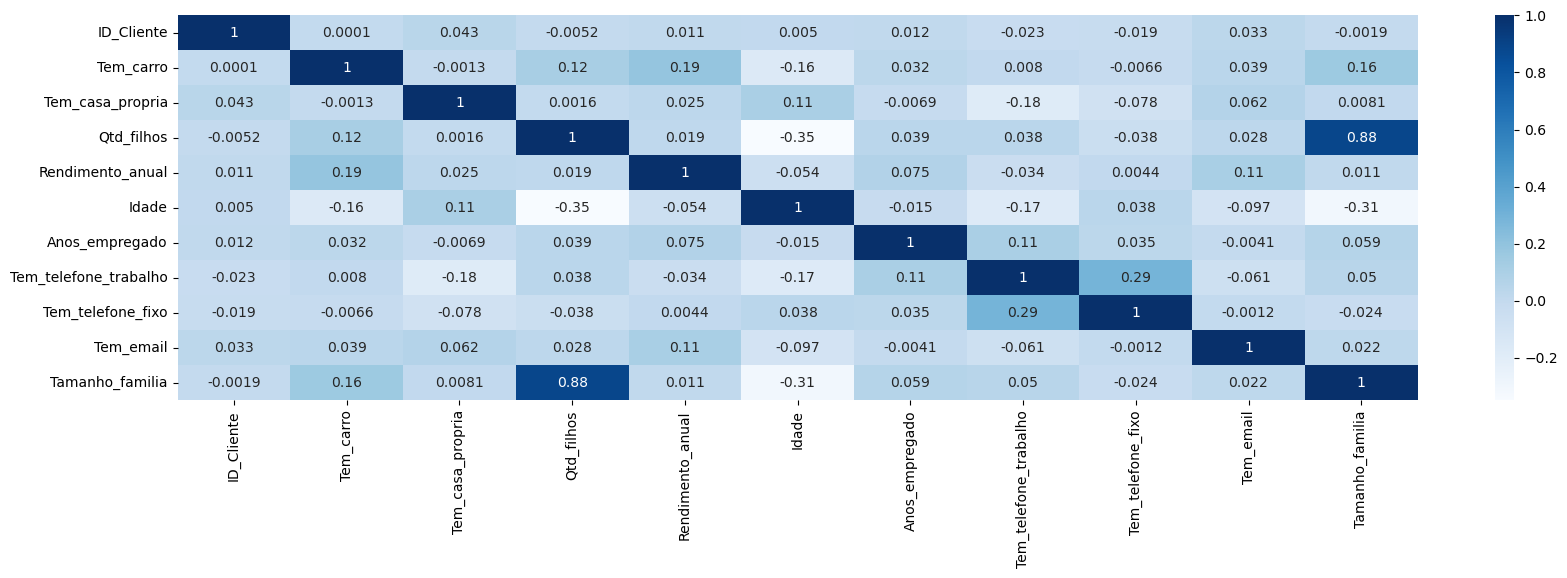

In [29]:
# Gerar grafico de corelação 

corr = df_cadastrados_limpo.select_dtypes(include=["number", "bool"]).corr()
plt.figure(figsize=(20, 5))
sns.heatmap(corr, cmap="Blues", annot=True)


In [30]:
# Remover coluna com alta corelação 

df_cadastrados_limpo = df_cadastrados_limpo.drop(['Qtd_filhos'], axis = 1)

In [31]:
# Atualizar sequencia dos dados

df_cadastrados_limpo=df_cadastrados_limpo[['ID_Cliente', 'Tem_carro', 'Tem_casa_propria', 
                                           'Tem_telefone_trabalho', 'Tem_telefone_fixo', 'Tem_email',
                                           'Tamanho_familia', 'Rendimento_anual', 'Idade', 'Anos_empregado',
                                           'Categoria_de_renda', 'Grau_escolaridade', 'Estado_civil',
                                           'Moradia', 'Ocupacao']]

df_cadastrados_limpo.head()

,ID_Cliente,Tem_carro,Tem_casa_propria,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Tamanho_familia,Rendimento_anual,Idade,Anos_empregado,Categoria_de_renda,Grau_escolaridade,Estado_civil,Moradia,Ocupacao
0,5008804,1,1,1,0,0,2.0,427500.0,32.868574,12.435574,Empregado,Ensino superior,União-estável,Apartamento alugado,Outros
1,5008805,1,1,1,0,0,2.0,427500.0,32.868574,12.435574,Empregado,Ensino superior,União-estável,Apartamento alugado,Outros
2,5008806,1,1,0,0,0,2.0,112500.0,58.793815,3.104787,Empregado,Ensino médio,Casado,Casa/apartamento próprio,Segurança
3,5008808,0,1,0,1,1,1.0,270000.0,52.321403,8.353354,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,Vendas
4,5008809,0,1,0,1,1,1.0,270000.0,52.321403,8.353354,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,Vendas


In [32]:
# Criar variavel com as colunas quantitativas

colunas_quantitativas = ['Tamanho_familia', 'Rendimento_anual', 'Idade', 'Anos_empregado']

In [33]:
# Ver o describe das colunas 

df_cadastrados_limpo[colunas_quantitativas].describe()

,Tamanho_familia,Rendimento_anual,Idade,Anos_empregado
count,438463.000000,4.384630e+05,438463.000000,438463.000000
mean,2.194461,1.875220e+05,43.800857,5.948371
std,0.897194,1.100832e+05,11.458262,6.564112
min,1.000000,2.610000e+04,20.504186,0.000000
25%,2.000000,1.215000e+05,34.262168,1.015763
50%,2.000000,1.611000e+05,42.793487,4.019247
75%,3.000000,2.250000e+05,53.345380,8.495725
max,20.000000,6.750000e+06,68.997994,47.998248


In [34]:
# Calcular percentual do Categoria_de_renda

df_cadastrados_limpo['Categoria_de_renda'].value_counts(normalize = True) * 100

Categoria_de_renda
Empregado              51.557144
Associado comercial    22.972520
Pensionista            17.214223
Servidor público        8.252236
Estudante               0.003877
Name: proportion, dtype: float64

In [35]:
# Calcular percentual do Grau_escolaridade

df_cadastrados_limpo['Grau_escolaridade'].value_counts(normalize = True) * 100

Grau_escolaridade
Ensino médio                  68.821314
Ensino superior               26.797928
Ensino superior incompleto     3.385690
Ensino fundamental             0.923909
Pós-graduação                  0.071158
Name: proportion, dtype: float64

In [36]:
# Calcular percentual do Estado_civil

df_cadastrados_limpo['Estado_civil'].value_counts(normalize = True) * 100

Estado_civil
Casado           68.367912
Solteiro         12.601976
União-estável     8.329323
Divorciado        6.214663
Viúvo             4.486125
Name: proportion, dtype: float64

In [37]:
# Calcular percentual do Moradia

df_cadastrados_limpo['Moradia'].value_counts(normalize = True) * 100

Moradia
Casa/apartamento próprio    89.801876
Mora com os pais             4.349740
Habitação pública            3.241094
Apartamento alugado          1.362259
Apartamento comercial        0.894032
Cooperativa habitacional     0.350999
Name: proportion, dtype: float64

In [38]:
# Calcular percentual do Ocupacao

df_cadastrados_limpo['Ocupacao'].value_counts(normalize = True) * 100

Ocupacao
Outros                  30.601670
Construção Civil        17.840730
Equipe principal         9.805388
Vendas                   9.371828
Gerência                 8.091219
Motorista                5.949191
Alta tecnologia          3.941724
Contabilidade            3.644549
Medicina                 3.083042
Cozinha                  1.841432
Segurança                1.822959
Limpeza                  1.332610
Serviço privado          0.787980
Baixa qualificação       0.488069
Secretariado             0.466174
Garçom                   0.379736
Corretor imobiliário     0.237420
RH                       0.176526
TI                       0.137754
Name: proportion, dtype: float64

#### **Aula 2 - Criando a variável target**

In [39]:
# Importar dados cadastrado 

link = 'https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/dd201a034223a16732c6f639b40600b26bd3129c/dados/clientes_aprovados.csv'
aprovados = pd.read_csv(link, sep= ",")

In [40]:
# Ver os tipos de dados

aprovados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID_Cliente      1048575 non-null  int64 
 1   Mes_referencia  1048575 non-null  int64 
 2   Faixa_atraso    1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [41]:
# Ver os dados 

aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias
4,5001712,0,pagamento realizado


In [42]:
# Fazer o filtro usando .query 

aprovados.query('ID_Cliente == 5001717')

,ID_Cliente,Mes_referencia,Faixa_atraso
120,5001717,0,pagamento realizado
121,5001717,-1,pagamento realizado
122,5001717,-2,pagamento realizado
123,5001717,-3,pagamento realizado
124,5001717,-4,pagamento realizado
125,5001717,-5,1-29 dias
126,5001717,-6,1-29 dias
127,5001717,-7,1-29 dias
128,5001717,-8,1-29 dias
129,5001717,-9,1-29 dias


In [43]:
# Fazer o filtro usando .query 

aprovados.query('ID_Cliente == 5001711')

,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias


In [44]:
# Fazer a contagem com base na coluna Faixa_atraso

aprovados.Faixa_atraso.value_counts()

Faixa_atraso
pagamento realizado    442031
1-29 dias              383120
nenhum empréstimo      209230
30-59 dias              11090
>150 dias                1693
60-89 dias                868
90-119 dias               320
120-149 dias              223
Name: count, dtype: int64

In [45]:
# Agrupar os dados 
# Criar um objeto GroupBy ou pandas.core.groupby.generic.DataFrameGroupBy --> Exemplo 5001711: [0, 1, 2, 3]

df_registros_credito_agrupados_ID = aprovados.groupby('ID_Cliente')

In [46]:
# Verificar o tipo do objeto

type(df_registros_credito_agrupados_ID)

pandas.core.groupby.generic.DataFrameGroupBy

In [47]:
# Ver os grupos criados

df_registros_credito_agrupados_ID.groups

{5001711: [0, 1, 2, 3], 5001712: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 5001713: [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 5001714: [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 5001715: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119], 5001717: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141], 5001718: [142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180], 5001719: [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 20

In [48]:
# Criar um pandas.core.series.Series com o min abertura 

ser_abertura = df_registros_credito_agrupados_ID['Mes_referencia'].apply(lambda x: min(x))
ser_abertura.name = 'Abertura'

ser_abertura.head()

ID_Cliente
5001711    -3
5001712   -18
5001713   -21
5001714   -14
5001715   -59
Name: Abertura, dtype: int64

In [49]:
# Realizar o merge entre os data frame 

df_clientes_aprovados = aprovados.merge(ser_abertura, on='ID_Cliente')
df_clientes_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura
0,5001711,0,nenhum empréstimo,-3
1,5001711,-1,1-29 dias,-3
2,5001711,-2,1-29 dias,-3
3,5001711,-3,1-29 dias,-3
4,5001712,0,pagamento realizado,-18


In [50]:
# # Criar um pandas.core.series.Series com o min abertura 

ser_final = df_registros_credito_agrupados_ID['Mes_referencia'].apply(lambda x: max(x))
ser_final.name = 'Final'

ser_final.head()

ID_Cliente
5001711    0
5001712    0
5001713    0
5001714    0
5001715    0
Name: Final, dtype: int64

In [51]:
# Realizar o merge entre os data frame 

df_clientes_aprovados = df_clientes_aprovados.merge(ser_final, on='ID_Cliente')
df_clientes_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final
0,5001711,0,nenhum empréstimo,-3,0
1,5001711,-1,1-29 dias,-3,0
2,5001711,-2,1-29 dias,-3,0
3,5001711,-3,1-29 dias,-3,0
4,5001712,0,pagamento realizado,-18,0


In [52]:
# Criar coluna Janela 

df_clientes_aprovados['Janela'] = df_clientes_aprovados['Final'] - df_clientes_aprovados['Abertura']
df_clientes_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela
0,5001711,0,nenhum empréstimo,-3,0,3
1,5001711,-1,1-29 dias,-3,0,3
2,5001711,-2,1-29 dias,-3,0,3
3,5001711,-3,1-29 dias,-3,0,3
4,5001712,0,pagamento realizado,-18,0,18


In [53]:
# Criara a coluna MOB (Month on Book)

"""

O que é MOB (Month on Book)?

MOB significa "Month on Book" (Mês no Livro, em tradução literal) e é uma métrica fundamental em serviços financeiros (como cartões de crédito, empréstimos, seguros) e 
em qualquer negócio baseado em subscrição.

Em termos simples, o MOB representa a "idade" da conta de um cliente, medida em meses, desde que ela foi aberta.

  * MOB 0: É o próprio mês em que a conta foi aberta (mês de "aquisição").
  * MOB 1: É o primeiro mês completo *após* a abertura da conta.
  * MOB 12: O cliente está completando um ano.

Por que o MOB é tão importante?

O MOB é a base para a Análise de Safras (Cohort Analysis).

Em vez de olhar para todos os seus clientes de uma só vez (o que mistura clientes novos e antigos), você os agrupa por "safra" (o mês em que entraram). 
O MOB permite que você compare o comportamento de diferentes safras ao longo do tempo.

Com o MOB, você pode responder perguntas como:

  * Risco e Inadimplência: Os clientes que abriram conta em Janeiro/2025 (Safra Jan/25) estão se tornando inadimplentes mais rápido (ex: no MOB 6) do que os clientes da safra de Jan/2024?
  * Rentabilidade: Em qual MOB, em média, um cliente começa a dar lucro?
  * Engajamento: Clientes mais novos (MOB 3) usam mais o app do que clientes mais antigos (MOB 24)?
  * Churn (Cancelamento): Existe um MOB específico em que a maioria dos clientes cancela o serviço?

"""

df_clientes_aprovados['MOB'] = df_clientes_aprovados['Mes_referencia'] - df_clientes_aprovados['Abertura']
df_clientes_aprovados.head()


,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela,MOB
0,5001711,0,nenhum empréstimo,-3,0,3,3
1,5001711,-1,1-29 dias,-3,0,3,2
2,5001711,-2,1-29 dias,-3,0,3,1
3,5001711,-3,1-29 dias,-3,0,3,0
4,5001712,0,pagamento realizado,-18,0,18,18


In [54]:
# Ver os dados unicos da Faixa_atraso

df_clientes_aprovados['Faixa_atraso'].unique()

array(['nenhum empréstimo', '1-29 dias', 'pagamento realizado',
       '30-59 dias', '60-89 dias', '90-119 dias', '120-149 dias',
       '>150 dias'], dtype=object)

In [55]:
# Criar dicionario para Faixa_atraso

dict_faixa_atraso_ind = {'nenhum empréstimo': 0, 'pagamento realizado': 1, '1-29 dias' : 2, 
       '30-59 dias': 3, '60-89 dias': 4, '90-119 dias': 5, '120-149 dias': 6,
       '>150 dias': 7}

In [56]:
# Criar coluna com Ind_faixa_atraso

df_clientes_aprovados['Ind_faixa_atraso'] = df_clientes_aprovados['Faixa_atraso'].map(dict_faixa_atraso_ind)
df_clientes_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela,MOB,Ind_faixa_atraso
0,5001711,0,nenhum empréstimo,-3,0,3,3,0
1,5001711,-1,1-29 dias,-3,0,3,2,2
2,5001711,-2,1-29 dias,-3,0,3,1,2
3,5001711,-3,1-29 dias,-3,0,3,0,2
4,5001712,0,pagamento realizado,-18,0,18,18,1


In [57]:
# Criar uma coluna de mau pagamento --> Target

df_clientes_aprovados['Mau'] = df_clientes_aprovados.apply(lambda x:1 if x['Ind_faixa_atraso']>3 else 0, axis=1)

In [58]:
# Ver nova coluna

df_clientes_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela,MOB,Ind_faixa_atraso,Mau
0,5001711,0,nenhum empréstimo,-3,0,3,3,0,0
1,5001711,-1,1-29 dias,-3,0,3,2,2,0
2,5001711,-2,1-29 dias,-3,0,3,1,2,0
3,5001711,-3,1-29 dias,-3,0,3,0,2,0
4,5001712,0,pagamento realizado,-18,0,18,18,1,0


In [59]:
# Agrupar os dados mantendo o primeiro registro

usar_versao_aula = 'n'

if usar_versao_aula.lower == 's':

    # Solução aula sem o DeprecationWarning

    df_registros_creditos_ID = (
        df_clientes_aprovados[['ID_Cliente', 'Abertura', 'Final', 'Janela']]
        .groupby('ID_Cliente')
        .apply(lambda x: x.iloc[0], include_groups=False)
        .reset_index(drop=True)
    )

else:
    
    # Solução do Copilot para pegar a primeira linha 

    df_registros_creditos_ID = (
        df_clientes_aprovados[['ID_Cliente', 'Abertura', 'Final', 'Janela']]
        .groupby('ID_Cliente', as_index=False)
        .first()
    )



In [60]:
# Ver os dados após o agrupamento

df_registros_creditos_ID.head()

,ID_Cliente,Abertura,Final,Janela
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59


In [67]:
# Ver qtd de clientes por abertura --> size considerando os NaN

df_denominador = (
    df_registros_creditos_ID
    .groupby('Abertura', as_index=False)
    .size()
    .rename(columns={'size': 'Qtd_Clientes'})
)

df_denominador.head()

,Abertura,Qtd_Clientes
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470


In [ ]:
# Ver qtd de clientes por abertura e MOB --> size considerando os NaN

df_vintage = (
    df_clientes_aprovados
    .groupby(['Abertura', 'MOB'], as_index=False)
    .size()
    .rename(columns={'size': 'Qtd_Clientes'})
)
df_vintage.head()


,Abertura,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,414
2,-60,2,410
3,-60,3,408
4,-60,4,403


In [69]:
# Fazer o merge entre o df_vintage e o df_denominador

df_vintage = pd.merge(df_vintage[['Abertura','MOB']], df_denominador, on='Abertura', how='left')

df_vintage.head()

,Abertura,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415


In [ ]:
# Calcular qtd de clientes mau pagador

df_vintage['Qtd_Mau'] = np.nan # Preencher coluna com nan

for j in range(-60,1):

    # Lista vazia para armazenar os IDs
    ls = []

    for i in range(0,61):

        # Encontrar todos os clientes que tem Mau = 1 
        due = list(df_clientes_aprovados.query('Mau == 1 and MOB == @i and Abertura == @j')['ID_Cliente'])

        # IDs dos clientes encontrados são armazendos na lista ls
        ls.extend(due)

        # Atribuir os dados na coluna Qtd_Mau
        df_vintage.loc[(df_vintage['MOB'] == i) & (df_vintage['Abertura'] == j), 'Qtd_Mau'] = len (set(ls))

# Calcular taxa de mau pagador
df_vintage['Taxa_de_Mau'] = df_vintage['Qtd_Mau'] / df_vintage['Qtd_Clientes']

df_vintage.head()

,Abertura,MOB,Qtd_Clientes,Qtd_Mau,Taxa_de_Mau
0,-60,0,415,0.0,0.0
1,-60,1,415,0.0,0.0
2,-60,2,415,0.0,0.0
3,-60,3,415,0.0,0.0
4,-60,4,415,0.0,0.0


In [73]:
# Fazer o pivot 

df_vintage_pivot = df_vintage.pivot(index= 'Abertura', columns= 'MOB', values='Taxa_de_Mau')
df_vintage_pivot.head()

MOB,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Abertura,,,,,,,,,,,,,,,,,,,,,
-60,0.0,0.0,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.0,0.0,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.0,0.0,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.0,0.0,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN


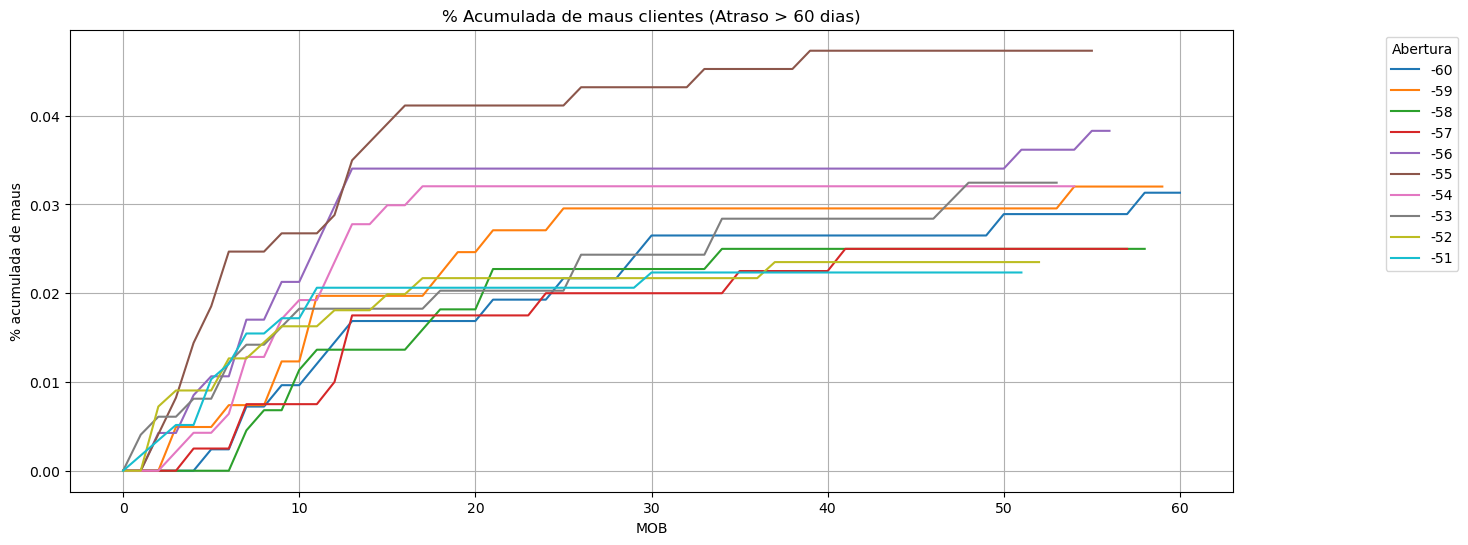

In [81]:
# Plotar o grafico

lst = [i for i in range(0,61)] # list compression

df_vintage_pivot[lst].T.iloc[:, :10].plot(legend=True, grid=True, title='% Acumulada de maus clientes (Atraso > 60 dias)', figsize=(15,6))
plt.xlabel('MOB')
plt.ylabel('% acumulada de maus')
plt.legend(bbox_to_anchor=(1.2,1), title='Abertura')
plt.show()


#### **Aula 3 - Machine Learning: Construindo a Pipeline**

#### **Aula 4 - Machine Learning: Escolhendo o Melhor Modelo**

#### **Aula 5 - Criando a aplicação**